In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image 
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.io import imread
from sklearn.linear_model import LogisticRegression
from skimage import data, exposure
from sklearn.model_selection import train_test_split,GridSearchCV
import numpy as np
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,f1_score
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  VotingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
def list_images_in_folder(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

In [3]:
def resize_image(image_path, output_path, target_size=(128, 128)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    
    # Convert RGBA or P to RGB
    if image.mode in ['RGBA', 'P']:
        image = image.convert('RGB')
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    image.save(output_path)

In [4]:
train_dir = os.listdir('./Tumor_Dataset/Training')
for number in train_dir:
    images = list_images_in_folder('./Tumor_Dataset/Training/' + number)
    for image in images:
        output_path = './Processed_Tumor_Dataset/Training/' + number + "/" + os.path.basename(image)
        resize_image(image, output_path, target_size=(128, 128))

In [5]:
train_dir = os.listdir('./Tumor_Dataset/Testing')
for number in train_dir:
    images = list_images_in_folder('./Tumor_Dataset/Testing/' + number)
    for image in images:
        output_path = './Processed_Tumor_Dataset/Testing/' + number + "/" + os.path.basename(image)
        resize_image(image, output_path, target_size=(128, 128))

In [6]:
zerosFolder=list_images_in_folder("./Processed_Tumor_Dataset/Training/notumor")
oneFolder=list_images_in_folder("./Processed_Tumor_Dataset/Training/glioma")
twoFolder=list_images_in_folder("./Processed_Tumor_Dataset/Training/meningioma")
threeFolder=list_images_in_folder("./Processed_Tumor_Dataset/Training/pituitary")

images = [zerosFolder,oneFolder,twoFolder,threeFolder]

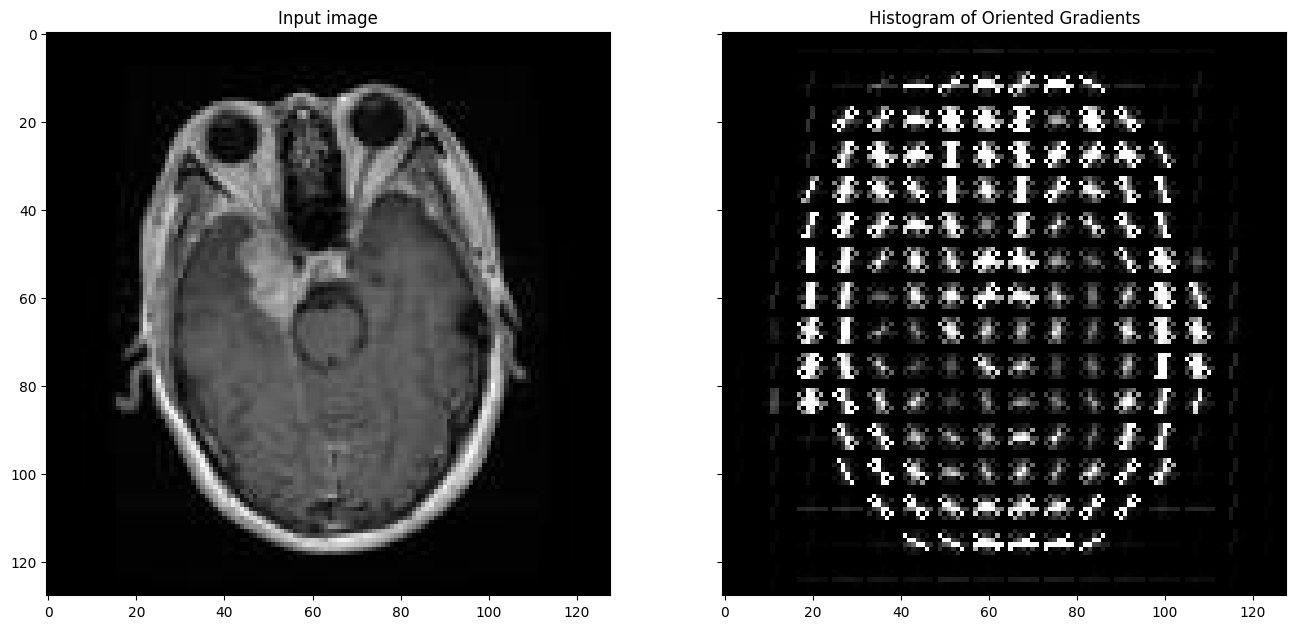

In [7]:
with Image.open(twoFolder[4]) as img:
    # Convert the image to grayscale
    gray_img = img.convert('L')
    # Convert the grayscale image to a NumPy array
    gray_img_array = np.array(gray_img)
    # Calculate the HOG features
    fd, hog_image = hog(gray_img_array, orientations=9, pixels_per_cell=(8,8), 
                    cells_per_block=(2, 2), visualize=True)
    # Display the images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 
    ax1.imshow(gray_img_array, cmap=plt.cm.gray) 
    ax1.set_title('Input image') 
    # Rescale histogram for better display 
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

In [8]:
def process_test_images(images, target_size=(128, 128)):
    features = []
    labels = []
    count = 0
    for i, image_set in enumerate(images):
        print(f"Processing category {i}, number of images: {len(image_set)}")
        for imgPath in image_set:
            # if count >= max_images:
            #     break
            try:
                print(f"Processing: {imgPath}")
                with Image.open(imgPath) as img:
                    img = img.resize(target_size)
                    gray_img = img.convert('L')
                    gray_img_array = np.array(gray_img)
                    fd, hog_image = hog(gray_img_array, orientations=9, pixels_per_cell=(8, 8), 
                                        cells_per_block=(2, 2), visualize=True)
                    features.append(fd)  
                    labels.append(i)     
                    count += 1
            except PermissionError:
                print(f"Permission denied: '{imgPath}'")
            except Exception as e:
                print(f"Error processing image '{imgPath}': {e}")
        # if count >= max_images:
        #     break
    return features, labels

# Process test images
features, labels = process_test_images(images)

Processing category 0, number of images: 1595
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-noTr_0000.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-noTr_0001.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-noTr_0002.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-noTr_0003.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-noTr_0004.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-noTr_0005.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-noTr_0006.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-noTr_0007.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-noTr_0008.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-noTr_0009.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-no_0010.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-no_0011.jpg
Processing: ./Processed_Tumor_Dataset/Training/notumor\Tr-no_0012.jpg
Processing: ./Processed_

In [9]:
# Print lengths to debug
print(f"Length of features: {len(features)}")
print(f"Length of labels: {len(labels)}")

Length of features: 5712
Length of labels: 5712


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Print the lengths of the training and testing sets
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 4569
Length of X_test: 1143
Length of y_train: 4569
Length of y_test: 1143


In [11]:
model=DecisionTreeClassifier(random_state=0)

model.fit(features,labels)

DecisionTreeClassifier(random_state=0)

In [12]:
model=RandomForestClassifier()

model.fit(features,labels)

RandomForestClassifier()

In [13]:
model=SVC( C=1000.0, kernel='linear',gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

model.fit(features,labels)

SVC(C=1000.0, gamma='auto', kernel='linear')

In [14]:
model=GaussianNB();
model.fit(features,labels)

GaussianNB()

In [15]:
def train_and_evaluate(classifier):
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    # Evaluate the classifier
    y_pred = classifier.predict(X_test)
    report = classification_report(y_test, y_pred)
    return report

# Instantiate multiple classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Support Vector Machine": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

In [16]:
# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    print(f"Training and evaluating {clf_name}...")
    report = train_and_evaluate(clf)
    print(f"\nClassification Report for {clf_name}:\n{report}\n")

Training and evaluating Decision Tree...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       346
           1       0.80      0.79      0.79       251
           2       0.67      0.64      0.66       247
           3       0.78      0.80      0.79       299

    accuracy                           0.78      1143
   macro avg       0.77      0.77      0.77      1143
weighted avg       0.78      0.78      0.78      1143


Training and evaluating K-Nearest Neighbors...

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       346
           1       0.90      0.94      0.92       251
           2       0.91      0.79      0.84       247
           3       0.91      0.99      0.95       299

    accuracy                           0.92      1143
   macro avg       0.92      0.91      0.91      1143
weight

In [17]:
# Create empty dictionaries to store metrics for each classifier
train_accuracy_scores = {}
train_precision_scores = {}
train_recall_scores = {}
train_f1_scores = {}

# Train and evaluate each classifier on the training dataset
for clf_name, clf in classifiers.items():
    print(f"Training and evaluating {clf_name} on the training dataset...")
    
    # Predict on the training dataset
    y_train_pred = clf.predict(X_train)
    
    # Compute metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    
    # Store metrics in dictionaries
    train_accuracy_scores[clf_name] = train_accuracy
    train_precision_scores[clf_name] = train_precision
    train_recall_scores[clf_name] = train_recall
    train_f1_scores[clf_name] = train_f1
    
    # Print results
    print(f"\nMetrics for {clf_name} on training dataset:")
    print(f"Accuracy: {train_accuracy}")
    print(f"Precision: {train_precision}")
    print(f"Recall: {train_recall}")
    print(f"F1 Score: {train_f1}\n")


Training and evaluating Decision Tree on the training dataset...

Metrics for Decision Tree on training dataset:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Training and evaluating K-Nearest Neighbors on the training dataset...

Metrics for K-Nearest Neighbors on training dataset:
Accuracy: 0.9531626176406216
Precision: 0.9532332483599979
Recall: 0.9531626176406216
F1 Score: 0.9529013107840124

Training and evaluating Gaussian Naive Bayes on the training dataset...

Metrics for Gaussian Naive Bayes on training dataset:
Accuracy: 0.7417377982052966
Precision: 0.7447609225021492
Recall: 0.7417377982052966
F1 Score: 0.7384739544013528

Training and evaluating Random Forest on the training dataset...

Metrics for Random Forest on training dataset:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Training and evaluating Support Vector Machine on the training dataset...

Metrics for Support Vector Machine on training dataset:
Accuracy: 0.9757058437294813
Precision: 0.97598

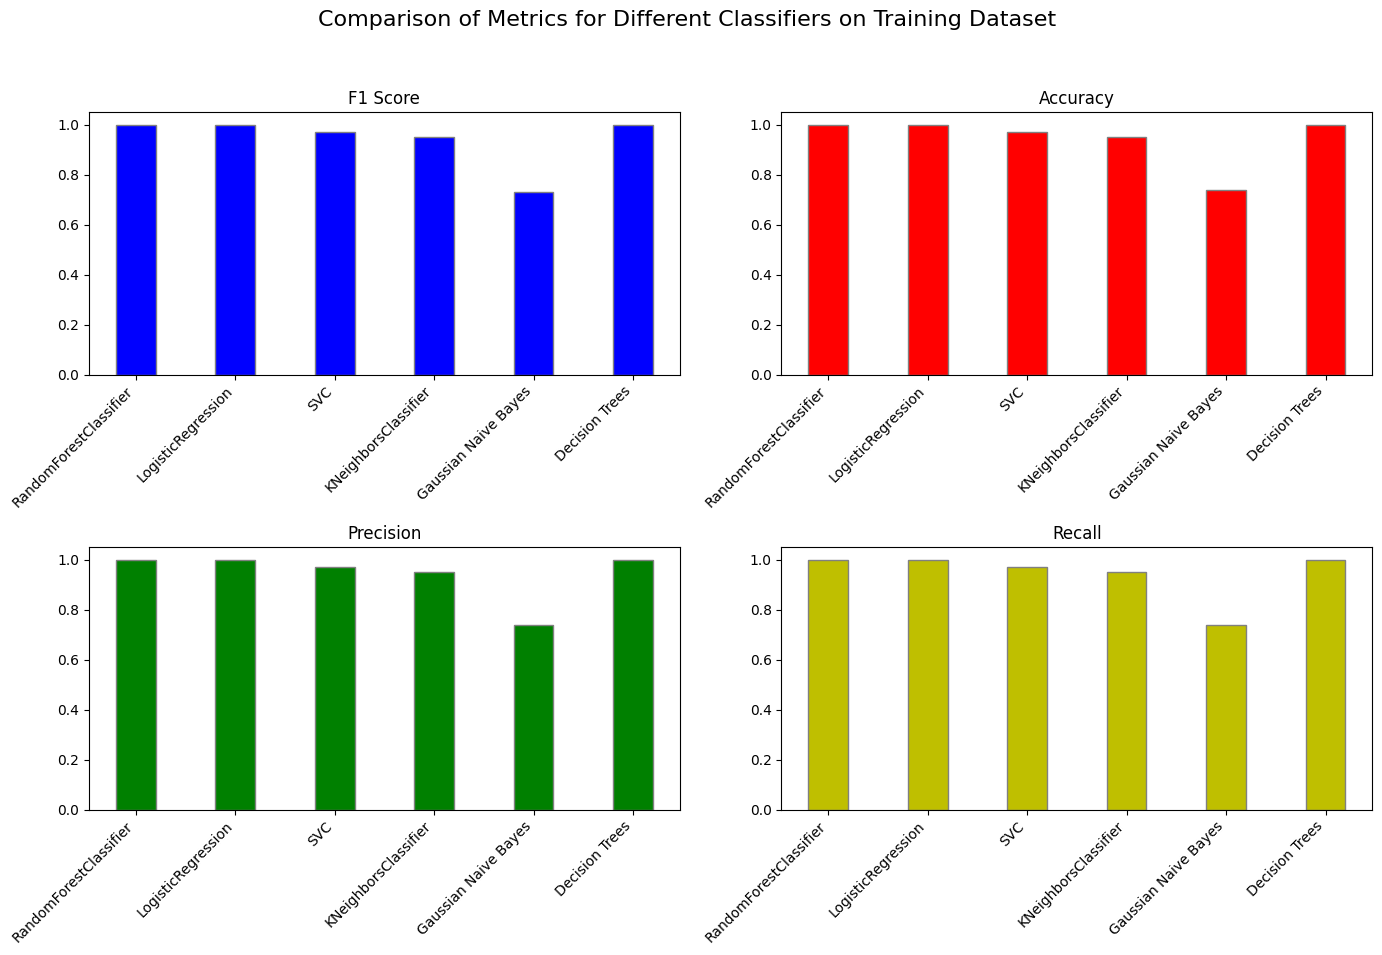

In [18]:

# Assuming these dictionaries contain the scores for each classifier
accuracy_scores = {
    'RandomForestClassifier': 1.0,
    'LogisticRegression': 1.0,
    'SVC': 0.97,
    'KNeighborsClassifier': 0.95,
    'Gaussian Naive Bayes': 0.74,
    'Decision Trees': 1.0
}

precision_scores = {
    'RandomForestClassifier': 1.0,
    'LogisticRegression': 1.0,
    'SVC': 0.97,
    'KNeighborsClassifier': 0.95,
    'Gaussian Naive Bayes': 0.74,
    'Decision Trees': 1.0
}

recall_scores = {
    'RandomForestClassifier': 1.0,
    'LogisticRegression': 1.0,
    'SVC': 0.97,
    'KNeighborsClassifier': 0.95,
    'Gaussian Naive Bayes': 0.74,
    'Decision Trees': 1.0
}

f1_scores = {
    'RandomForestClassifier': 1.0,
    'LogisticRegression': 1.0,
    'SVC': 0.97,
    'KNeighborsClassifier': 0.95,
    'Gaussian Naive Bayes': 0.73,
    'Decision Trees': 1.0
}

# Extract metric scores
f1_scores_list = list(f1_scores.values())
accuracy_scores_list = list(accuracy_scores.values())
precision_scores_list = list(precision_scores.values())
recall_scores_list = list(recall_scores.values())

# Define classifiers names
classifiers_names = list(f1_scores.keys())

# Set width of bar
bar_width = 0.4

# Set positions of bars on X axis
r1 = np.arange(len(f1_scores_list))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot F1 Score
axes[0, 0].bar(r1, f1_scores_list, color='b', width=bar_width, edgecolor='grey')
axes[0, 0].set_title('F1 Score')
axes[0, 0].set_xticks(r1)
axes[0, 0].set_xticklabels(classifiers_names, rotation=45, ha="right")

# Plot Accuracy
axes[0, 1].bar(r1, accuracy_scores_list, color='r', width=bar_width, edgecolor='grey')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xticks(r1)
axes[0, 1].set_xticklabels(classifiers_names, rotation=45, ha="right")

# Plot Precision
axes[1, 0].bar(r1, precision_scores_list, color='g', width=bar_width, edgecolor='grey')
axes[1, 0].set_title('Precision')
axes[1, 0].set_xticks(r1)
axes[1, 0].set_xticklabels(classifiers_names, rotation=45, ha="right")

# Plot Recall
axes[1, 1].bar(r1, recall_scores_list, color='y', width=bar_width, edgecolor='grey')
axes[1, 1].set_title('Recall')
axes[1, 1].set_xticks(r1)
axes[1, 1].set_xticklabels(classifiers_names, rotation=45, ha="right")

# Set the overall title
fig.suptitle('Comparison of Metrics for Different Classifiers on Training Dataset', fontsize=16)

# Adjust layout to prevent overlap
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()


In [19]:
zerosFolder=list_images_in_folder("./Processed_Tumor_Dataset/Testing/notumor")
oneFolder=list_images_in_folder("./Processed_Tumor_Dataset/Testing/glioma")
twoFolder=list_images_in_folder("./Processed_Tumor_Dataset/Testing/meningioma")
threeFolder=list_images_in_folder("./Processed_Tumor_Dataset/Testing/pituitary")

images = [zerosFolder,oneFolder,twoFolder,threeFolder]

In [20]:
def process_test_images(images, target_size=(128, 128)):
    testFeatures = []
    testLabels = []
    count = 0
    for i, image_set in enumerate(images):
        print(f"Processing category {i}, number of images: {len(image_set)}")
        for imgPath in image_set:
            # if count >= max_images:
            #     break
            try:
                print(f"Processing: {imgPath}")
                with Image.open(imgPath) as img:
                    img = img.resize(target_size)
                    gray_img = img.convert('L')
                    gray_img_array = np.array(gray_img)
                    fd, hog_image = hog(gray_img_array, orientations=9, pixels_per_cell=(8, 8), 
                                        cells_per_block=(2, 2), visualize=True)
                    testFeatures.append(fd)  # Append to testFeatures
                    testLabels.append(i)     # Append to testLabels
                    count += 1
            except PermissionError:
                print(f"Permission denied: '{imgPath}'")
            except Exception as e:
                print(f"Error processing image '{imgPath}': {e}")
        # if count >= max_images:
        #     break
    return testFeatures, testLabels

# Process test images
testFeatures, testLabels = process_test_images(images)

Processing category 0, number of images: 405
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0000.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0001.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0002.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0003.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0004.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0005.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0006.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0007.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0008.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0009.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-no_0010.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-no_0011.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-no_0012.jpg
Processing: ./Processed_Tumor_Dataset/

In [21]:
# Print lengths to debug
print(f"Length of features: {len(testFeatures)}")
print(f"Length of labels: {len(testLabels)}")

Length of features: 1311
Length of labels: 1311


In [22]:
X_train, X_test, y_train, y_test = train_test_split(testFeatures, testLabels, test_size=0.2, random_state=42)

Training and evaluating Decision Tree on testing dataset...

Classification Report for Decision Tree on testing dataset:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        77
           1       0.73      0.79      0.76        62
           2       0.72      0.63      0.67        62
           3       0.86      0.81      0.83        62

    accuracy                           0.79       263
   macro avg       0.79      0.79      0.79       263
weighted avg       0.79      0.79      0.79       263


Confusion Matrix for Decision Tree on testing dataset:
[[71  4  1  1]
 [ 2 49 10  1]
 [ 5 12 39  6]
 [ 6  2  4 50]]

Training and evaluating K-Nearest Neighbors on testing dataset...

Classification Report for K-Nearest Neighbors on testing dataset:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        77
           1       0.92      0.92      0.92        62
           2       0.88      0

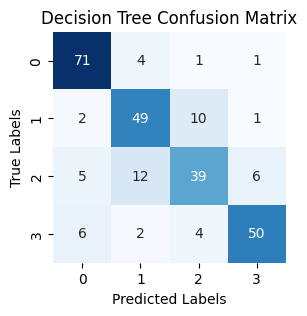

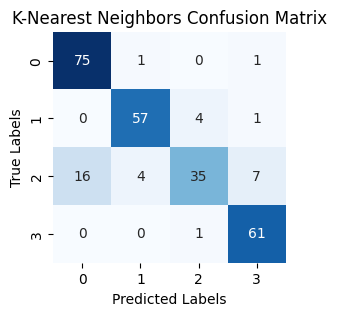

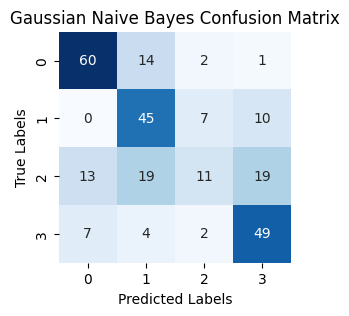

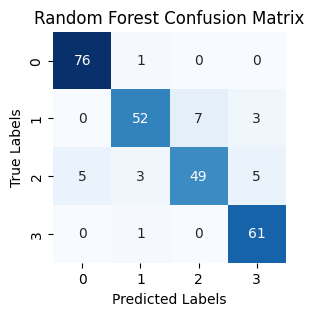

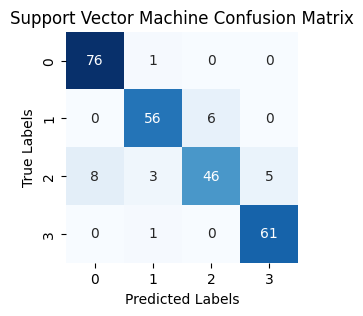

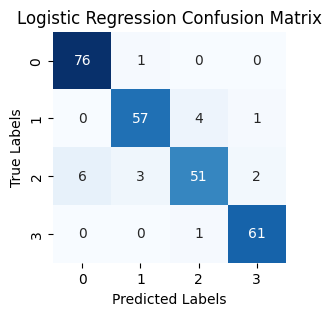

In [23]:


# Function to train and evaluate classifier on testing dataset
def train_and_evaluate_on_test(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return report, cm

# Create a dictionary to store confusion matrices
confusion_matrices = {}

# Train and evaluate each classifier on testing dataset
for clf_name, clf in classifiers.items():
    print(f"Training and evaluating {clf_name} on testing dataset...")
    
    # Evaluate the classifier on the testing dataset
    report, cm = train_and_evaluate_on_test(clf, X_test, y_test)
    
    # Store the confusion matrix
    confusion_matrices[clf_name] = cm
    
    # Print results
    print(f"\nClassification Report for {clf_name} on testing dataset:\n{report}\n")
    print(f"Confusion Matrix for {clf_name} on testing dataset:\n{cm}\n")

# Plot confusion matrices separately
for clf_name, cm in confusion_matrices.items():
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{clf_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [24]:


# Create empty dictionaries to store metrics for each classifier
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Train and evaluate each classifier on testing dataset
for clf_name, clf in classifiers.items():
    print(f"Training and evaluating {clf_name} on testing dataset...")
    
    # Predict on the testing dataset
    y_pred = clf.predict(X_test)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store metrics in dictionaries
    accuracy_scores[clf_name] = accuracy
    precision_scores[clf_name] = precision
    recall_scores[clf_name] = recall
    f1_scores[clf_name] = f1
    
    # Print results
    print(f"\nMetrics for {clf_name} on testing dataset:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n")


Training and evaluating Decision Tree on testing dataset...

Metrics for Decision Tree on testing dataset:
Accuracy: 0.7946768060836502
Precision: 0.7933561618071089
Recall: 0.7946768060836502
F1 Score: 0.7922819030841818

Training and evaluating K-Nearest Neighbors on testing dataset...

Metrics for K-Nearest Neighbors on testing dataset:
Accuracy: 0.8669201520912547
Precision: 0.8697342581373
Recall: 0.8669201520912547
F1 Score: 0.8578024711440055

Training and evaluating Gaussian Naive Bayes on testing dataset...

Metrics for Gaussian Naive Bayes on testing dataset:
Accuracy: 0.6273764258555133
Precision: 0.6130421537887227
Recall: 0.6273764258555133
F1 Score: 0.5967064524880946

Training and evaluating Random Forest on testing dataset...

Metrics for Random Forest on testing dataset:
Accuracy: 0.9049429657794676
Precision: 0.9044483319084311
Recall: 0.9049429657794676
F1 Score: 0.9030144743561386

Training and evaluating Support Vector Machine on testing dataset...

Metrics for Sup

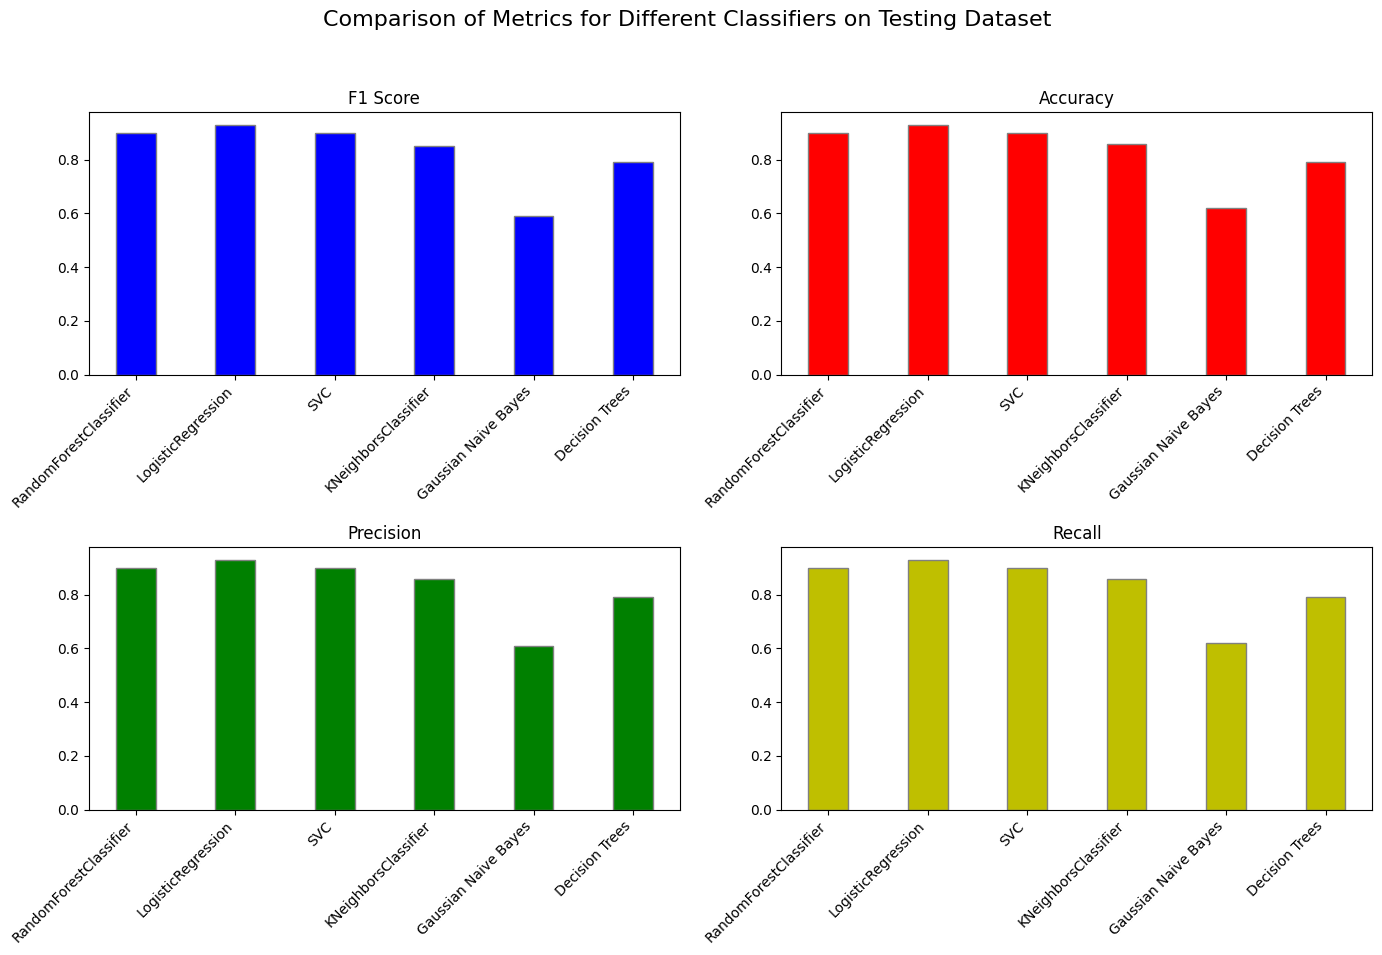

In [25]:

# Assuming these dictionaries contain the scores for each classifier
accuracy_scores = {
    'RandomForestClassifier': 0.90,
    'LogisticRegression': 0.93,
    'SVC': 0.90,
    'KNeighborsClassifier': 0.86,
    'Gaussian Naive Bayes': 0.62,
    'Decision Trees': 0.79
}

precision_scores = {
    'RandomForestClassifier': 0.90,
    'LogisticRegression': 0.93,
    'SVC': 0.90,
    'KNeighborsClassifier': 0.86,
    'Gaussian Naive Bayes': 0.61,
    'Decision Trees': 0.79
}

recall_scores = {
    'RandomForestClassifier': 0.90,
    'LogisticRegression': 0.93,
    'SVC': 0.90,
    'KNeighborsClassifier': 0.86,
    'Gaussian Naive Bayes': 0.62,
    'Decision Trees': 0.79
}

f1_scores = {
    'RandomForestClassifier': 0.90,
    'LogisticRegression': 0.93,
    'SVC': 0.90,
    'KNeighborsClassifier': 0.85,
    'Gaussian Naive Bayes': 0.59,
    'Decision Trees': 0.79
}

# Extract metric scores
f1_scores_list = list(f1_scores.values())
accuracy_scores_list = list(accuracy_scores.values())
precision_scores_list = list(precision_scores.values())
recall_scores_list = list(recall_scores.values())

# Define classifiers names
classifiers_names = list(f1_scores.keys())

# Set width of bar
bar_width = 0.4

# Set positions of bars on X axis
r1 = np.arange(len(f1_scores_list))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot F1 Score
axes[0, 0].bar(r1, f1_scores_list, color='b', width=bar_width, edgecolor='grey')
axes[0, 0].set_title('F1 Score')
axes[0, 0].set_xticks(r1)
axes[0, 0].set_xticklabels(classifiers_names, rotation=45, ha="right")

# Plot Accuracy
axes[0, 1].bar(r1, accuracy_scores_list, color='r', width=bar_width, edgecolor='grey')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xticks(r1)
axes[0, 1].set_xticklabels(classifiers_names, rotation=45, ha="right")

# Plot Precision
axes[1, 0].bar(r1, precision_scores_list, color='g', width=bar_width, edgecolor='grey')
axes[1, 0].set_title('Precision')
axes[1, 0].set_xticks(r1)
axes[1, 0].set_xticklabels(classifiers_names, rotation=45, ha="right")

# Plot Recall
axes[1, 1].bar(r1, recall_scores_list, color='y', width=bar_width, edgecolor='grey')
axes[1, 1].set_title('Recall')
axes[1, 1].set_xticks(r1)
axes[1, 1].set_xticklabels(classifiers_names, rotation=45, ha="right")

# Set the overall title
fig.suptitle('Comparison of Metrics for Different Classifiers on Testing Dataset', fontsize=16)

# Adjust layout to prevent overlap
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()


In [26]:
train_accuracy_scores = {
    'RandomForestClassifier': 1.0,
    'LogisticRegression': 1.0,
    'SVC': 0.97,
    'KNeighborsClassifier': 0.95,
    'Gaussian Naive Bayes': 0.74,
    'Decision Trees': 1.0
}

train_precision_scores = {
    'RandomForestClassifier': 1.0,
    'LogisticRegression': 1.0,
    'SVC': 0.97,
    'KNeighborsClassifier': 0.95,
    'Gaussian Naive Bayes': 0.74,
    'Decision Trees': 1.0
}

train_recall_scores = {
    'RandomForestClassifier': 1.0,
    'LogisticRegression': 1.0,
    'SVC': 0.97,
    'KNeighborsClassifier': 0.95,
    'Gaussian Naive Bayes': 0.74,
    'Decision Trees': 1.0
}

train_f1_scores = {
    'RandomForestClassifier': 1.0,
    'LogisticRegression': 1.0,
    'SVC': 0.97,
    'KNeighborsClassifier': 0.95,
    'Gaussian Naive Bayes': 0.73,
    'Decision Trees': 1.0
}

In [27]:
test_accuracy_scores = {
    'RandomForestClassifier': 0.90,
    'LogisticRegression': 0.93,
    'SVC': 0.90,
    'KNeighborsClassifier': 0.86,
    'Gaussian Naive Bayes': 0.62,
    'Decision Trees': 0.79
}

test_precision_scores = {
    'RandomForestClassifier': 0.90,
    'LogisticRegression': 0.93,
    'SVC': 0.90,
    'KNeighborsClassifier': 0.86,
    'Gaussian Naive Bayes': 0.61,
    'Decision Trees': 0.79
}

test_recall_scores = {
    'RandomForestClassifier': 0.90,
    'LogisticRegression': 0.93,
    'SVC': 0.90,
    'KNeighborsClassifier': 0.86,
    'Gaussian Naive Bayes': 0.62,
    'Decision Trees': 0.79
}

test_f1_scores = {
    'RandomForestClassifier': 0.90,
    'LogisticRegression': 0.93,
    'SVC': 0.90,
    'KNeighborsClassifier': 0.85,
    'Gaussian Naive Bayes': 0.59,
    'Decision Trees': 0.79
}

In [28]:
# Function to plot metrics
def plot_combined_metrics(train_metrics, test_metrics, metric_name):
    classifiers = list(train_metrics.keys())
    train_values = list(train_metrics.values())
    test_values = list(test_metrics.values())

    x = np.arange(len(classifiers))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label='Training')
    rects2 = ax.bar(x + width/2, test_values, width, label='Testing')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Classifiers')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by classifier and dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(classifiers, rotation=45, ha="right")
    ax.legend()


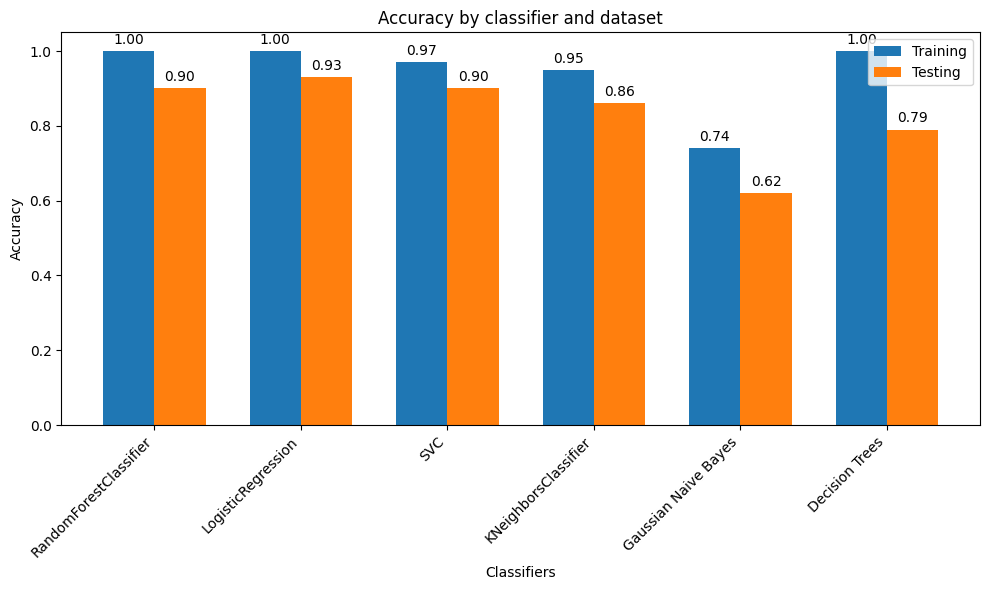

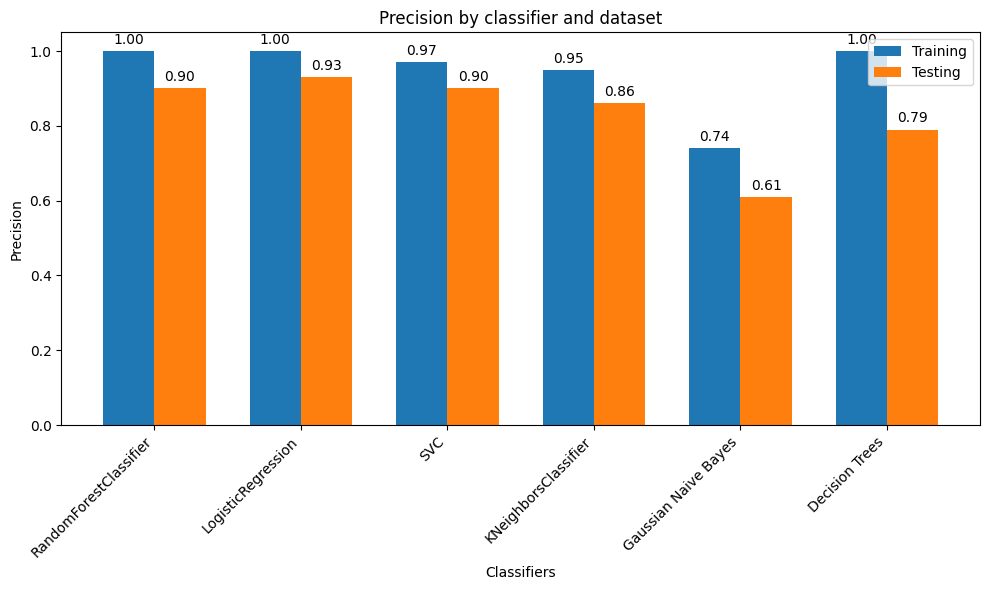

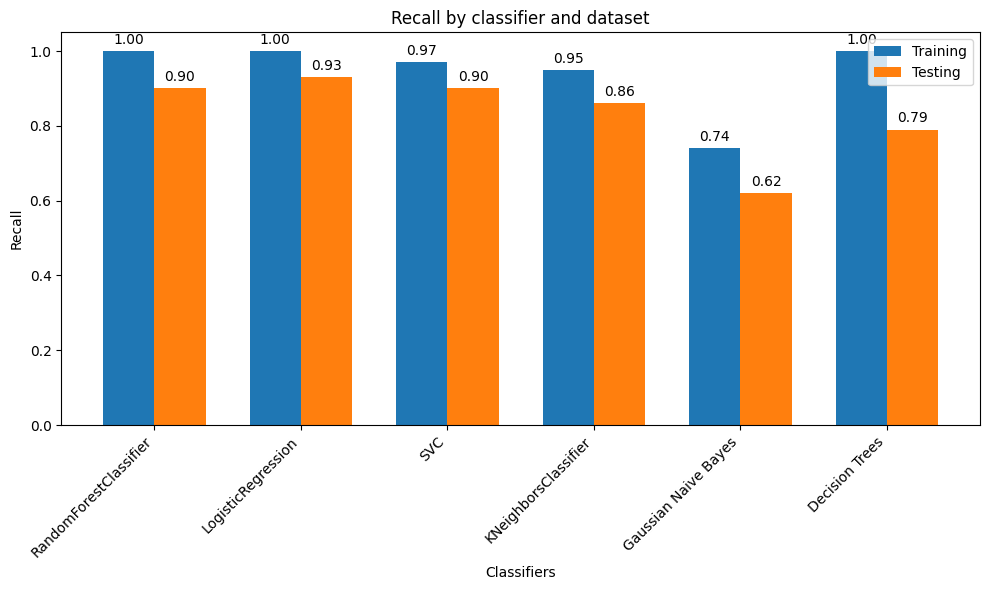

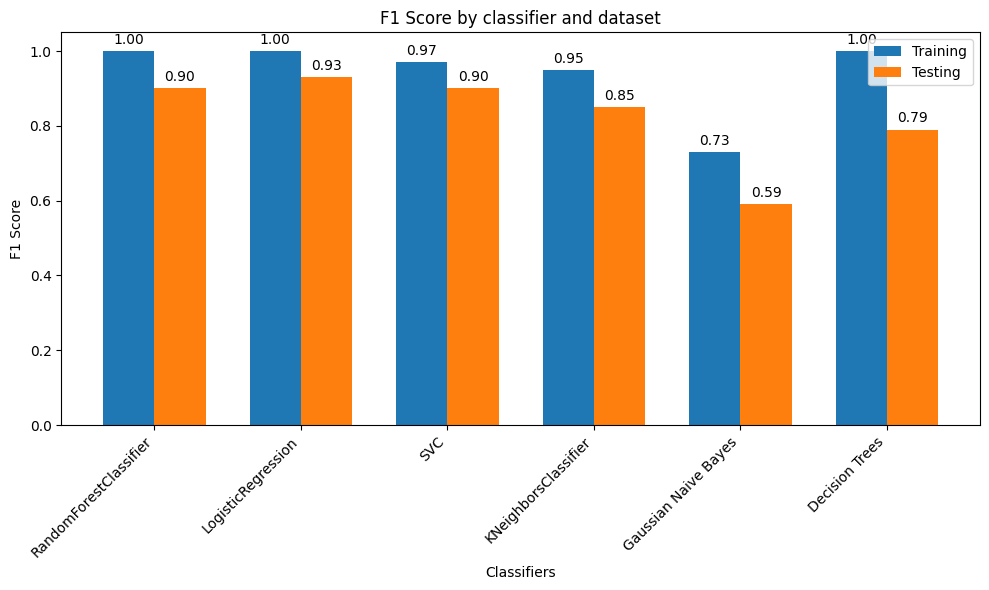

In [29]:
# Function to plot metrics
def plot_combined_metrics(train_metrics, test_metrics, metric_name):
    classifiers = list(train_metrics.keys())
    train_values = list(train_metrics.values())
    test_values = list(test_metrics.values())

    x = np.arange(len(classifiers))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label='Training')
    rects2 = ax.bar(x + width/2, test_values, width, label='Testing')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Classifiers')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by classifier and dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(classifiers, rotation=45, ha="right")
    ax.legend()

    # Add labels
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Plot metrics
plot_combined_metrics(train_accuracy_scores, test_accuracy_scores, 'Accuracy')
plot_combined_metrics(train_precision_scores, test_precision_scores, 'Precision')
plot_combined_metrics(train_recall_scores, test_recall_scores, 'Recall')
plot_combined_metrics(train_f1_scores, test_f1_scores, 'F1 Score')

In [30]:
def process_images(images, target_size=(128, 128)):
    features = []
    labels = []
    for i, image_set in enumerate(images):
        print(f"Processing category {i}, number of images: {len(image_set)}")
        for imgPath in image_set:
            try:
                print(f"Processing: {imgPath}")
                with Image.open(imgPath) as img:
                    img = img.resize(target_size)
                    # Convert grayscale images to RGB
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    img_array = np.array(img)
                    features.append(img_array)
                    labels.append(i)
            except PermissionError:
                print(f"Permission denied: '{imgPath}'")
            except Exception as e:
                print(f"Error processing image '{imgPath}': {e}")
    return np.array(features), np.array(labels)

# Process images
X, y = process_images(images)

# Normalize pixel values to [0, 1]
X = X / 255.0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Processing category 0, number of images: 405
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0000.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0001.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0002.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0003.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0004.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0005.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0006.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0007.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0008.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-noTr_0009.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-no_0010.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-no_0011.jpg
Processing: ./Processed_Tumor_Dataset/Testing/notumor\Te-no_0012.jpg
Processing: ./Processed_Tumor_Dataset/

In [31]:

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=4)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: glioma, meningioma, pituitary, no tumor
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=20, validation_data=(X_test, y_test_categorical))


C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 477ms/step - accuracy: 0.3579 - loss: 1.5503 - val_accuracy: 0.5247 - val_loss: 0.9865
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accuracy: 0.6488 - loss: 0.8726 - val_accuracy: 0.7338 - val_loss: 0.7181
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - accuracy: 0.7387 - loss: 0.6719 - val_accuracy: 0.7338 - val_loss: 0.6350
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.7756 - loss: 0.5299 - val_accuracy: 0.7414 - val_loss: 0.6300
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 471ms/step - accuracy: 0.8090 - loss: 0.4675 - val_accuracy: 0.7947 - val_loss: 0.5493
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - accuracy: 0.8639 - loss: 0.3652 - val_accuracy: 0.7909 - val_loss: 0.4908
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 596ms/step - accuracy: 0.8912 - loss: 0.3301 - val_accuracy: 0.7947 - val_loss: 0.5552
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 465ms/step - accuracy: 0.9097 - loss: 0.2351 - val_accu

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8287 - loss: 0.8151
Test accuracy: 0.8288973569869995


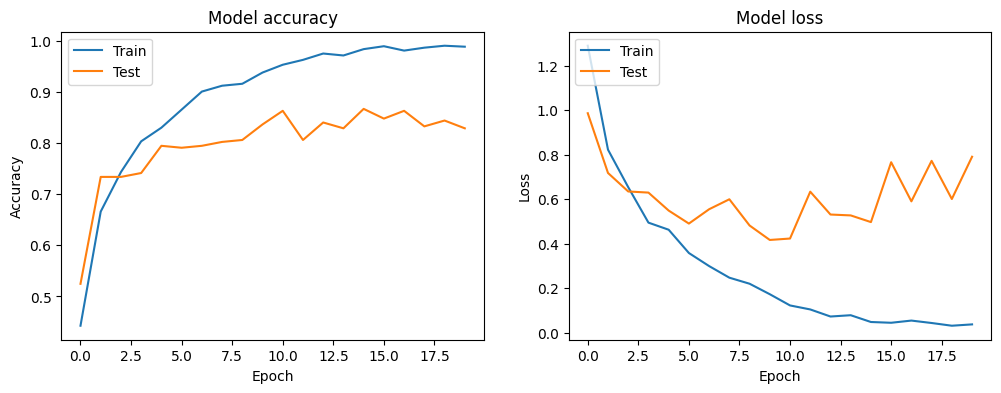

In [32]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_categorical)
print(f"Test accuracy: {test_acc}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [35]:
# Function to load and preprocess a single image for prediction
def preprocess_single_image(image_path):
    with Image.open(image_path) as img:
        img = img.resize((128, 128))
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_array = np.array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
The predicted class is: glioma


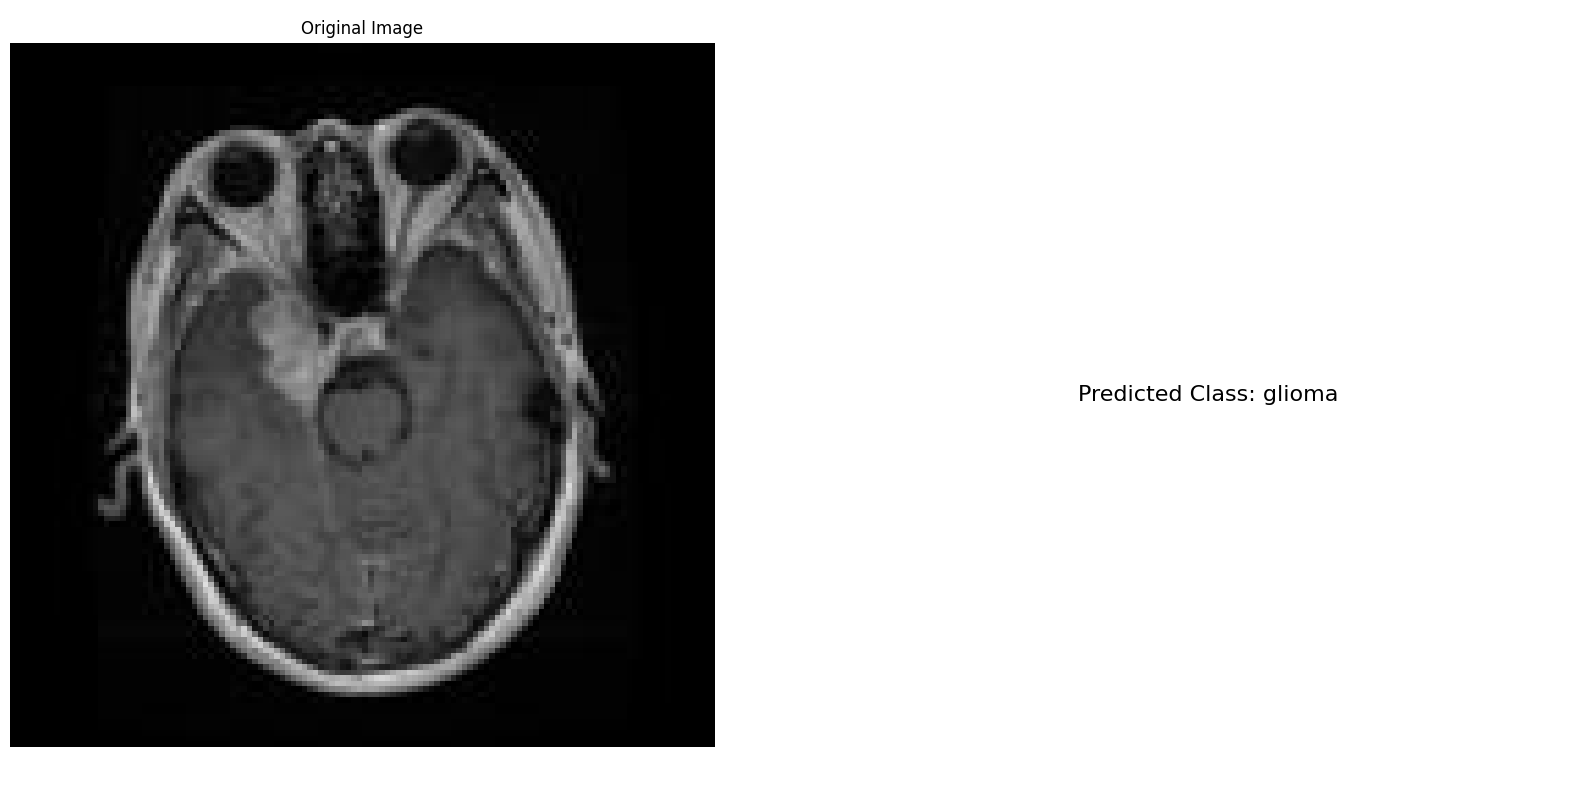

In [46]:
def predict_image_class(image_path, model):
    preprocessed_image = preprocess_single_image(image_path)
    prediction = model.predict(preprocessed_image)
    class_indices = {0: 'notumor', 1: 'glioma', 2: 'meningioma', 3: 'pituitary'}
    predicted_class = class_indices[np.argmax(prediction)]
    return predicted_class

# Test the prediction function
test_img_path = 'Experiment_Dataset/Tr-gl_0015.jpg'  # Replace with the path to your test image

# Predict the class
predicted_class = predict_image_class(test_img_path, model)
print(f"The predicted class is: {predicted_class}")

# Optional: Display the prediction result alongside the original image
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(122)
plt.text(0.5, 0.5, f"Predicted Class: {predicted_class}", fontsize=16, ha='center', va='center')
plt.axis('off')
plt.show()